In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import random
import torch
from torch.utils.data import DataLoader, TensorDataset
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
import importlib
import modules
import modules.nn_based
importlib.reload(modules.nn_based)
from modules.nn_based import *
from sklearn.model_selection import train_test_split

In [3]:
batch_size = 32
num_epochs = 20
train_split = 0.8

In [ ]:
def plot_results(noisy, clean, denoised, title=""):
    """
    Plot a few examples comparing the noisy input, clean signal, and denoised output.
    """
    num_examples = 3
    plt.figure(figsize=(8, 4))
    for i in range(num_examples):
        plt.subplot(num_examples, 1, i+1)
        plt.plot(clean[i].squeeze().cpu().numpy(), label="Clean Signal", linewidth=2)
        plt.plot(noisy[i].squeeze().cpu().numpy(), label="Noisy Signal", alpha=0.5)
        plt.plot(denoised[i].squeeze().cpu().detach().numpy(), label="Denoised Output", linestyle="--")
        plt.legend(loc="upper right")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

##### 1D Noisy Signal Generation 
Observation = Sine Wave + Noise ~ N(0, 1)

(10000, 100) (10000, 100) (10000, 100)


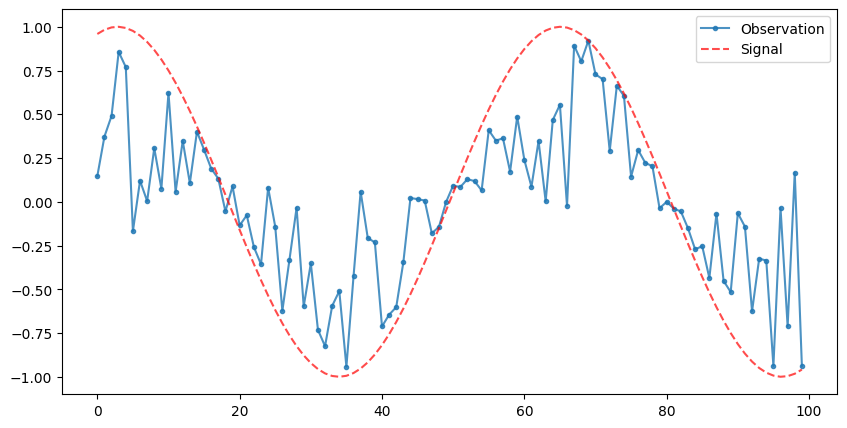

In [14]:
def create_1d_data(n_depth = 100, n_samples=1000, decay=0.1):
    
    signal_arr, noise_arr, obs_arr = [], [], []

    for _ in range(n_samples):

        x_vals = np.linspace(-5, 5, n_depth)
        signal = np.sin(x_vals)
        noise = np.random.normal(0, 1, size=n_depth)

        _r = np.random.rand(n_depth)
        observation = _r * signal + (1 - _r) * decay * noise

        signal_arr.append(signal)
        noise_arr.append(noise)
        obs_arr.append(observation)

    return np.array(obs_arr), np.array(signal_arr), np.array(noise_arr) 


n_samples = 10000
rn = random.randint(0, n_samples)

observation, signal, noise = create_1d_data(n_samples=n_samples)
print(observation.shape, signal.shape, noise.shape)

plt.figure(figsize=(10, 5))

plt.plot(observation[rn], label="Observation", alpha=0.8, marker='.')
plt.plot(signal[rn], label="Signal", linestyle="dashed", alpha=0.7, color = 'red')
plt.legend()
plt.show()


In [6]:
observation_train, observation_val, signal_train, signal_val = train_test_split(observation, signal, test_size = 1 - train_split, random_state=28)

print('Shape: ', observation_train.shape, signal_train.shape, observation_val.shape, signal_val.shape)

observation_train = torch.tensor(observation_train, dtype=torch.float32)
signal_train = torch.tensor(signal_train, dtype=torch.float32)
observation_val = torch.tensor(observation_val, dtype=torch.float32)
signal_val = torch.tensor(signal_val, dtype=torch.float32)

dataset_train = TensorDataset(observation_train, signal_train)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = TensorDataset(observation_val, signal_val)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

print(train_loader, val_loader)

Shape:  (8000, 100) (8000, 100) (2000, 100) (2000, 100)
<torch.utils.data.dataloader.DataLoader object at 0x000001FDD72B3B00> <torch.utils.data.dataloader.DataLoader object at 0x000001FDD95AA600>


Training Denoising Autoencoder (DAE)...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 100]              64
              ReLU-2              [-1, 16, 100]               0
         AvgPool1d-3               [-1, 16, 50]               0
            Conv1d-4                [-1, 8, 50]             392
              ReLU-5                [-1, 8, 50]               0
         AvgPool1d-6                [-1, 8, 25]               0
            Conv1d-7                [-1, 8, 25]             200
              ReLU-8                [-1, 8, 25]               0
          Upsample-9                [-1, 8, 50]               0
           Conv1d-10               [-1, 16, 50]             400
             ReLU-11               [-1, 16, 50]               0
         Upsample-12              [-1, 16, 100]               0
           Conv1d-13               [-1, 1, 100]              49

Epoch 1/20:   0%|          | 0/250 [00:00<?, ?it/s, loss=0.5610]

Epoch [1/20] Train Loss: 0.1197 | Val Loss: 0.0085


Epoch [2/20] Train Loss: 0.0065 | Val Loss: 0.0050


Epoch [3/20] Train Loss: 0.0043 | Val Loss: 0.0036


Epoch [4/20] Train Loss: 0.0033 | Val Loss: 0.0029


Epoch [5/20] Train Loss: 0.0029 | Val Loss: 0.0026


Epoch [6/20] Train Loss: 0.0026 | Val Loss: 0.0025


Epoch [7/20] Train Loss: 0.0025 | Val Loss: 0.0023


Epoch [8/20] Train Loss: 0.0024 | Val Loss: 0.0027


Epoch [9/20] Train Loss: 0.0023 | Val Loss: 0.0024


Epoch [10/20] Train Loss: 0.0022 | Val Loss: 0.0022


Epoch [11/20] Train Loss: 0.0021 | Val Loss: 0.0022


Epoch [12/20] Train Loss: 0.0021 | Val Loss: 0.0021


Epoch [13/20] Train Loss: 0.0021 | Val Loss: 0.0020


Epoch [14/20] Train Loss: 0.0021 | Val Loss: 0.0020


Epoch [15/20] Train Loss: 0.0020 | Val Loss: 0.0019


Epoch [16/20] Train Loss: 0.0020 | Val Loss: 0.0019


Epoch [17/20] Train Loss: 0.0019 | Val Loss: 0.0019


Epoch [18/20] Train Loss: 0.0019 | Val Loss: 0.0019


Epoch [19/20] Train Loss: 0.0019 | Val Loss: 0.0020


Epoch [20/20] Train Loss: 0.0019 | Val Loss: 0.0019


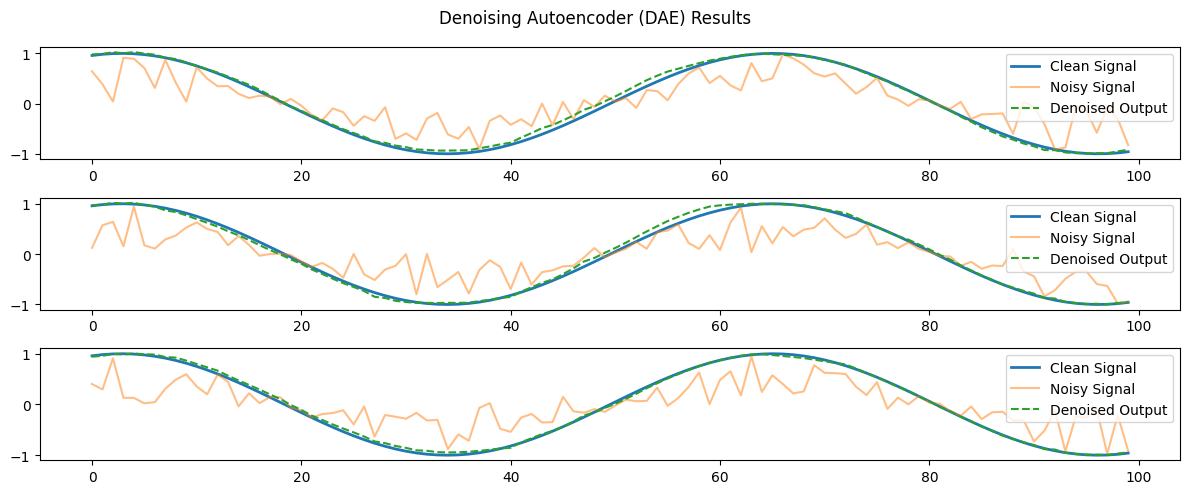

In [9]:
# ----- Denoising Autoencoder (DAE) -----

print("Training Denoising Autoencoder (DAE)...")
dae = DenoisingAutoencoder()
dae.summary()

dae, train_loss, val_loss = train_model(dae, train_loader=train_loader, val_loader=val_loader, num_epochs=num_epochs, return_loss=True)

# Evaluate DAE on a few examples
dae.eval()
device = next(dae.parameters()).device

with torch.no_grad():
    sample_noisy = observation_val[:3].to(device)
    sample_noisy = sample_noisy.reshape(sample_noisy.shape[0], 1, -1)
    dae_output = dae(sample_noisy)

plot_results(observation_val, signal_val, dae_output, title="Denoising Autoencoder (DAE) Results")

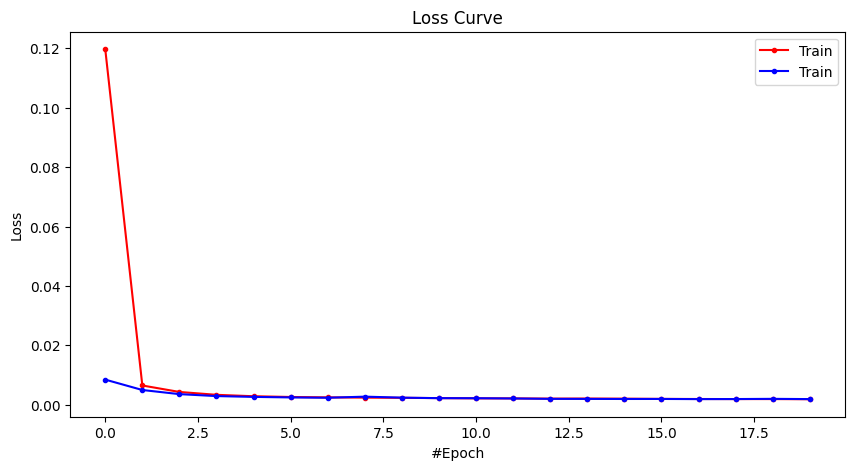

In [ ]:
fig = plt.figure(figsize = (6, 3))

plt.plot(range(0, num_epochs), train_loss, label = 'Train', color = 'red', marker = '.')
plt.plot(range(0, num_epochs), val_loss, label = 'Train', color = 'blue', marker = '.')
plt.xlabel('#Epoch')
plt.ylabel('Loss')

plt.title('Loss Curve')

plt.legend()
plt.grid()
plt.show()

Training Basic CNN for Denoising...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 100]             128
              Tanh-2              [-1, 32, 100]               0
            Conv1d-3              [-1, 64, 100]           6,208
              Tanh-4              [-1, 64, 100]               0
            Conv1d-5              [-1, 64, 100]          12,352
              Tanh-6              [-1, 64, 100]               0
            Conv1d-7              [-1, 32, 100]           6,176
              Tanh-8              [-1, 32, 100]               0
            Conv1d-9               [-1, 1, 100]              97
Total params: 24,961
Trainable params: 24,961
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.29
Params size (MB): 0.10
Estimated Total Size (MB): 0.39
---------

Epoch [1/20] Train Loss: 0.0248 | Val Loss: 0.0122


Epoch [2/20] Train Loss: 0.0117 | Val Loss: 0.0106


Epoch [3/20] Train Loss: 0.0098 | Val Loss: 0.0091


Epoch [4/20] Train Loss: 0.0082 | Val Loss: 0.0078


Epoch [5/20] Train Loss: 0.0073 | Val Loss: 0.0071


Epoch [6/20] Train Loss: 0.0068 | Val Loss: 0.0068


Epoch [7/20] Train Loss: 0.0063 | Val Loss: 0.0061


Epoch [8/20] Train Loss: 0.0060 | Val Loss: 0.0057


Epoch [9/20] Train Loss: 0.0057 | Val Loss: 0.0054


Epoch [10/20] Train Loss: 0.0055 | Val Loss: 0.0054


Epoch [11/20] Train Loss: 0.0053 | Val Loss: 0.0051


Epoch [12/20] Train Loss: 0.0052 | Val Loss: 0.0051


Epoch [13/20] Train Loss: 0.0050 | Val Loss: 0.0049


Epoch [14/20] Train Loss: 0.0048 | Val Loss: 0.0047


Epoch [15/20] Train Loss: 0.0048 | Val Loss: 0.0046


Epoch [16/20] Train Loss: 0.0046 | Val Loss: 0.0046


Epoch [17/20] Train Loss: 0.0046 | Val Loss: 0.0046


Epoch [18/20] Train Loss: 0.0045 | Val Loss: 0.0044


Epoch [19/20] Train Loss: 0.0044 | Val Loss: 0.0043


Epoch [20/20] Train Loss: 0.0044 | Val Loss: 0.0042


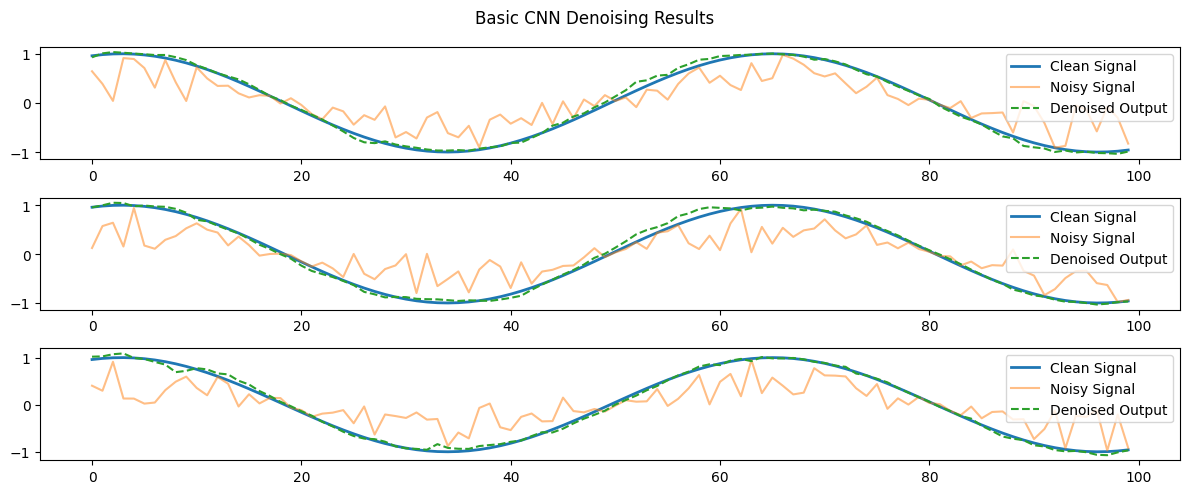

In [11]:
# ----- Basic CNN for Denoising -----

num_epochs = 20

print("Training Basic CNN for Denoising...")
cnn = DenoisingCNN()
cnn.summary()

cnn, train_loss, val_loss = train_model(cnn, train_loader=train_loader, val_loader=val_loader, num_epochs=num_epochs, return_loss=True)

# Evaluate CNN on a few examples
cnn.eval()
device = next(cnn.parameters()).device

with torch.no_grad():
    sample_noisy = observation_val[:3].to(device)
    sample_noisy = sample_noisy.reshape(sample_noisy.shape[0], 1, -1)
    cnn_output = cnn(sample_noisy)

plot_results(observation_val, signal_val, cnn_output, title="Basic CNN Denoising Results")

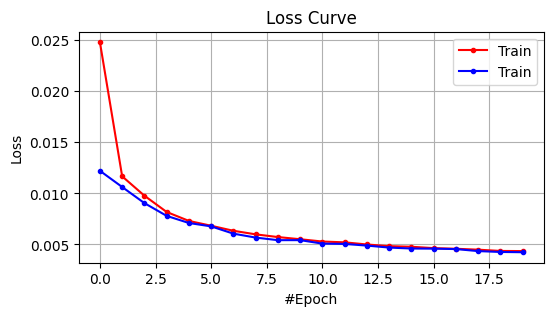

In [15]:
fig = plt.figure(figsize = (6, 3))

plt.plot(range(0, num_epochs), train_loss, label = 'Train', color = 'red', marker = '.')
plt.plot(range(0, num_epochs), val_loss, label = 'Train', color = 'blue', marker = '.')
plt.xlabel('#Epoch')
plt.ylabel('Loss')

plt.title('Loss Curve')

plt.legend()
plt.grid()
plt.show()

#### DDPM Denoising (1d)
The Reverse Diffusion Process is a posterior sampling method conditioned on a noisy image. Here, instead of generating an image by conditioning on isotropic Gaussian noise, it denoises the given noisy image through the reverse process. 